## Baseline CNN, CNN+SVM, CNN+XGBoost with epochs =10

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.

Training Baseline CNN...
Epoch 1/10
119/119 [==============================] - 196s 2s/step - loss: 2.2354 - accuracy: 0.2322 - precision: 0.4848 - recall: 0.0210 - auc: 0.7004 - val_loss: 1.8749 - val_accuracy: 0.3369 - val_precision: 0.6061 - val_recall: 0.0211 - val_auc: 0.8247
Epoch 2/10
119/119 [==============================] - 137s 1s/step - loss: 1.9177 - accuracy: 0.3208 - precision: 0.5740 - recall: 0.0826 - auc: 0.8099 - val_loss: 1.7398 - val_accuracy: 0.3823 - val_precision: 0.6769 - val_recall: 0.1394 - val_auc: 0.8588
Epoch 3/10
119/119 [==============================] - 151s 1s/step - loss: 1.7502 

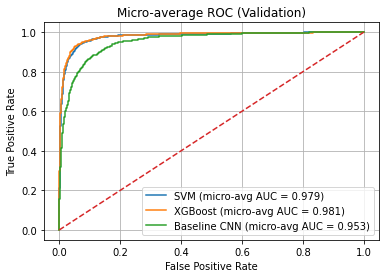


Saved results to model_comparison_results.csv


In [5]:
# ============================================================
# Baseline CNN, CNN+SVM, CNN+XGBoost with proper feature extraction
# Plant Seedlings classification (12 classes)
# - Functional API (no "model has never been called" errors)
# - Clean generators for training vs feature extraction
# - Metrics: accuracy, precision, recall, F1 (micro), AUC (OVR)
# - Micro-average ROC curve plotting
# ============================================================

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------
# Reproducibility
# -------------------------
np.random.seed(19064722)
tf.random.set_seed(19064722)

# -------------------------
# Paths & basic params
# -------------------------
train_dir = "C:/Users/MBIZA/Downloads/train/train"   # folder with class subfolders

# test_dir  = "Downloads/test/test"   # unlabeled test images (optional)

img_size = (128, 128)
img_shape = (img_size[0], img_size[1], 3)
batch_size = 32
epochs = 10

# -------------------------
# Data generators
#   - aug_train/val used to TRAIN the CNN (with augmentation)
#   - feat_train/val used to EXTRACT FEATURES (no shuffle, just rescale)
# -------------------------
aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# For validation during training: turn off heavy augmentation implicitly by using the same datagen but subset=validation.
# (rescale is applied; geometric transforms are rarely applied to validation)
aug_train = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

aug_val = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

class_names = list(aug_train.class_indices.keys())
num_classes = len(class_names)
print("Classes:", class_names)

# Separate clean generators for feature extraction (no shuffle, only rescale)
plain_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

feat_train = plain_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

feat_val = plain_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# -------------------------
# Build CNN (Functional API)
# -------------------------
def build_cnn(
    filters1=32, filters2=64, filters3=128,
    kernel_size=(3,3), pool_size=(2,2),
    dense_units=256, dropout_rate=0.5,
    activation="relu", lr=1e-3
):
    inputs = Input(shape=img_shape)

    x = Conv2D(filters1, kernel_size, padding="same", activation=activation)(inputs)
    x = MaxPooling2D(pool_size=pool_size)(x)

    x = Conv2D(filters2, kernel_size, padding="same", activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)

    x = Conv2D(filters3, kernel_size, padding="same", activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)

    x = Flatten()(x)
    # Name this layer so we can extract features reliably
    features = Dense(dense_units, activation=activation, name="features")(x)
    x = Dropout(dropout_rate)(features)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs, name="baseline_cnn")
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=lr),
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )
    return model

# -------------------------
# Train Baseline CNN
# -------------------------
cnn = build_cnn()
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

print("\nTraining Baseline CNN...")
t0 = time.time()
history = cnn.fit(
    aug_train,
    validation_data=aug_val,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)
t_cnn = time.time() - t0

val_loss, val_acc, val_prec, val_rec, val_auc = cnn.evaluate(aug_val, verbose=0)
val_f1 = 2 * (val_prec * val_rec) / (val_prec + val_rec + 1e-7)

results = {
    "Baseline CNN": {
        "accuracy": val_acc,
        "precision": val_prec,
        "recall": val_rec,
        "f1_score": val_f1,
        "auc": val_auc,
        "training_time_s": t_cnn
    }
}

print("Baseline CNN metrics:", results["Baseline CNN"])

# -------------------------
# Feature extractor (works immediately in Functional API)
# -------------------------
feature_extractor = Model(inputs=cnn.input, outputs=cnn.get_layer("features").output)

# Helper to extract features and labels from a generator (no shuffle)
def extract_features(gen, extractor):
    # Predict features for ALL samples (predict() on generator covers them sequentially)
    feats = extractor.predict(gen, steps=len(gen), verbose=0)
    labels_onehot = gen.labels if hasattr(gen, "labels") else gen.classes
    # Note: Keras ImageDataGenerator stores class indices in `classes`; `labels` mirrors it.
    # But safest: use gen.classes
    y = gen.classes
    return feats, y

print("\nExtracting features...")
X_train, y_train = extract_features(feat_train, feature_extractor)
X_val, y_val = extract_features(feat_val, feature_extractor)

print("Train features shape:", X_train.shape, " Val features shape:", X_val.shape)

# -------------------------
# CNN + SVM
#   - Standardize features helps SVM converge and perform better
# -------------------------
print("\nTraining CNN + SVM...")
svm_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False for sparse-like safety; features are dense so either is fine
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

t0 = time.time()
svm_pipe.fit(X_train, y_train)
t_svm = time.time() - t0

svm_pred = svm_pipe.predict(X_val)
svm_prob = svm_pipe.predict_proba(X_val)

svm_metrics = {
    "accuracy": accuracy_score(y_val, svm_pred),
    "precision": precision_score(y_val, svm_pred, average="micro"),
    "recall": recall_score(y_val, svm_pred, average="micro"),
    "f1_score": f1_score(y_val, svm_pred, average="micro"),
    "auc": roc_auc_score(y_val, svm_prob, multi_class="ovr"),
    "training_time_s": t_svm
}
results["CNN + SVM"] = svm_metrics
print("CNN + SVM metrics:", svm_metrics)

# -------------------------
# CNN + XGBoost
# -------------------------
print("\nTraining CNN + XGBoost...")
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

t0 = time.time()
xgb.fit(X_train, y_train)
t_xgb = time.time() - t0

xgb_pred = xgb.predict(X_val)
xgb_prob = xgb.predict_proba(X_val)

xgb_metrics = {
    "accuracy": accuracy_score(y_val, xgb_pred),
    "precision": precision_score(y_val, xgb_pred, average="micro"),
    "recall": recall_score(y_val, xgb_pred, average="micro"),
    "f1_score": f1_score(y_val, xgb_pred, average="micro"),
    "auc": roc_auc_score(y_val, xgb_prob, multi_class="ovr"),
    "training_time_s": t_xgb
}
results["CNN + XGBoost"] = xgb_metrics
print("CNN + XGBoost metrics:", xgb_metrics)

# -------------------------
# Comparison table
# -------------------------
df_results = pd.DataFrame(results).T
print("\n=== Model Comparison ===")
print(df_results)

# -------------------------
# ROC: micro-average for SVM and XGBoost
# -------------------------
# Binarize labels for micro-average ROC
y_val_bin = label_binarize(y_val, classes=np.arange(num_classes))

# CNN micro-average ROC
cnn_prob = cnn.predict(aug_val, verbose=0)  # softmax outputs
y_val_bin_cnn = label_binarize(feat_val.classes, classes=np.arange(num_classes))

fpr_cnn, tpr_cnn, _ = roc_curve(y_val_bin_cnn.ravel(), cnn_prob.ravel())
auc_cnn = auc(fpr_cnn, tpr_cnn)
# SVM micro-average ROC
fpr_svm, tpr_svm, _ = roc_curve(y_val_bin.ravel(), svm_prob.ravel())
auc_svm = auc(fpr_svm, tpr_svm)

# XGB micro-average ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_val_bin.ravel(), xgb_prob.ravel())
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()

plt.plot(fpr_svm, tpr_svm, label=f"SVM (micro-avg AUC = {auc_svm:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (micro-avg AUC = {auc_xgb:.3f})")
plt.plot(fpr_cnn, tpr_cnn, label=f"Baseline CNN (micro-avg AUC = {auc_cnn:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-average ROC (Validation)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -------------------------
# Optional: Save results to CSV
# -------------------------
df_results.to_csv("model_comparison_results.csv", index=True)
print("\nSaved results to model_comparison_results.csv")

## Applying Models to test data

In [15]:
# ============================================================
# Predictions on unlabeled test images
# ============================================================
test_dir = "C:/Users/MBIZA/Downloads/test"

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory="C:/Users/MBIZA/Downloads/test",
    classes=["test"],              # tells it to read just the "test" folder
    target_size=img_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)


# -------------------------
# CNN Predictions
# -------------------------
cnn_prob_test = cnn.predict(test_generator, verbose=0)
cnn_pred_test = np.argmax(cnn_prob_test, axis=1)
cnn_pred_labels = [class_names[i] for i in cnn_pred_test]

cnn_counts = pd.Series(cnn_pred_labels).value_counts()
print("\nCNN predicted class counts:")
print(cnn_counts)

# -------------------------
# CNN + SVM Predictions
# -------------------------
# Need test features first
X_test, _ = extract_features(test_generator, feature_extractor)

svm_pred_test = svm_pipe.predict(X_test)
svm_pred_labels = [class_names[i] for i in svm_pred_test]

svm_counts = pd.Series(svm_pred_labels).value_counts()
print("\nCNN+SVM predicted class counts:")
print(svm_counts)

# -------------------------
# CNN + XGBoost Predictions
# -------------------------
xgb_pred_test = xgb.predict(X_test)
xgb_pred_labels = [class_names[i] for i in xgb_pred_test]

xgb_counts = pd.Series(xgb_pred_labels).value_counts()
print("\nCNN+XGBoost predicted class counts:")
print(xgb_counts)

# -------------------------
# Save all predictions to CSV
# -------------------------
df_preds = pd.DataFrame({
    "filename": [os.path.basename(f) for f in test_generator.filenames],
    "CNN_pred": cnn_pred_labels,
    "SVM_pred": svm_pred_labels,
    "XGB_pred": xgb_pred_labels
})

df_preds.to_csv("test_predictions.csv", index=False)
print("\nSaved per-image predictions to test_predictions.csv")


Found 794 images belonging to 1 classes.

CNN predicted class counts:
Loose Silky-bent             142
Small-flowered Cranesbill    109
Common Chickweed             106
Charlock                      92
Scentless Mayweed             81
Sugar beet                    72
Cleavers                      64
Fat Hen                       48
Maize                         31
Common wheat                  30
Shepherds Purse               18
Black-grass                    1
Name: count, dtype: int64

CNN+SVM predicted class counts:
Loose Silky-bent             140
Common Chickweed             107
Small-flowered Cranesbill     97
Scentless Mayweed             95
Fat Hen                       81
Charlock                      62
Sugar beet                    59
Cleavers                      49
Common wheat                  38
Maize                         33
Shepherds Purse               31
Black-grass                    2
Name: count, dtype: int64

CNN+XGBoost predicted class counts:
Loose Silky-bent

## Effect of other activation functions

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.

🚀 Training model with activation: relu
30/30 [==============================] - 14s 433ms/step

📊 relu -> Precision: 0.2413, Recall: 0.2420, F1: 0.1680

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        52
                 Charlock       0.24      0.06      0.10        78
                 Cleavers       0.00      0.00      0.00        57
         Common Chickweed       0.30      0.84      0.44       122
             Common wheat       0.00      0.00      0.00        44
                  Fat Hen       0.29      0.05      0.09        95
         Loose Silky-bent       0.45      0.92      0.60       130
                    Maize       0.00      0.00      0.00        44
        Scentless Mayweed       1.00      0.01      0.02       103
          Shepherds Purse       0.00      0.00      0.00        46


C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classifi

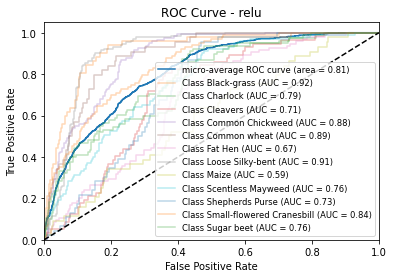


🚀 Training model with activation: leakyrelu
30/30 [==============================] - 14s 428ms/step

📊 leakyrelu -> Precision: 0.1491, Recall: 0.2016, F1: 0.1405

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        52
                 Charlock       0.22      0.03      0.05        78
                 Cleavers       0.00      0.00      0.00        57
         Common Chickweed       0.28      0.36      0.31       122
             Common wheat       0.00      0.00      0.00        44
                  Fat Hen       0.22      0.02      0.04        95
         Loose Silky-bent       0.29      0.98      0.44       130
                    Maize       0.15      0.41      0.22        44
        Scentless Mayweed       0.26      0.27      0.27       103
          Shepherds Purse       0.00      0.00      0.00        46
Small-flowered Cranesbill       0.38      0.35      0.36        99
        

C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classifi

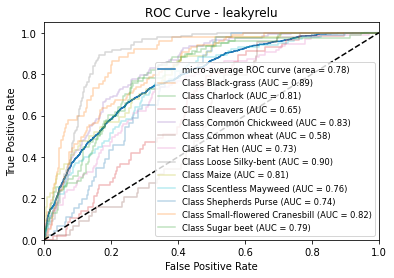


🚀 Training model with activation: gelu
30/30 [==============================] - 16s 496ms/step

📊 gelu -> Precision: 0.2087, Recall: 0.2385, F1: 0.1964

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.28      0.40      0.33        52
                 Charlock       0.47      0.09      0.15        78
                 Cleavers       0.00      0.00      0.00        57
         Common Chickweed       0.26      0.58      0.36       122
             Common wheat       0.00      0.00      0.00        44
                  Fat Hen       0.19      0.15      0.16        95
         Loose Silky-bent       0.41      0.82      0.54       130
                    Maize       0.00      0.00      0.00        44
        Scentless Mayweed       0.33      0.15      0.20       103
          Shepherds Purse       0.00      0.00      0.00        46
Small-flowered Cranesbill       0.31      0.26      0.28        99
               Sug

C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classifi

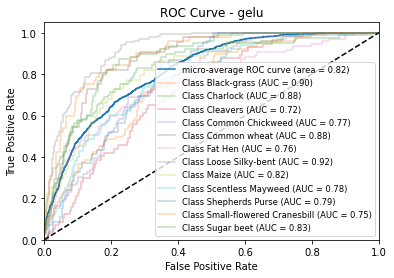

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import gelu
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# ==============================
# Data Preprocessing
# ==============================
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_dir = "C:/Users/MBIZA/Downloads/train/train"
epochs = 1

aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

aug_train = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

aug_val = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

num_classes = len(aug_train.class_indices)
class_names = list(aug_train.class_indices.keys())

# ==============================
# Build CNN with custom activation
# ==============================
def build_model(activation="relu"):
    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape=(*IMG_SIZE, 3)))
    if activation == "leakyrelu":
        model.add(LeakyReLU(alpha=0.01))
    elif activation == "gelu":
        model.add(tf.keras.layers.Activation(gelu))
    else:
        model.add(tf.keras.layers.Activation(activation))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, (3,3)))
    if activation == "leakyrelu":
        model.add(LeakyReLU(alpha=0.01))
    elif activation == "gelu":
        model.add(tf.keras.layers.Activation(gelu))
    else:
        model.add(tf.keras.layers.Activation(activation))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    if activation == "gelu":
        model.add(Dense(128, activation=gelu))
    elif activation == "leakyrelu":
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(Dense(128, activation=activation))

    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# ==============================
# Train & Evaluate with ROC/F1
# ==============================
from sklearn.metrics import precision_score, recall_score, f1_score

activations = ["relu", "leakyrelu", "gelu"]
histories = {}

for act in activations:
    print(f"\n🚀 Training model with activation: {act}")
    model = build_model(act)
    history = model.fit(
        aug_train,
        validation_data=aug_val,
        epochs=epochs,
        verbose=1
    )
    histories[act] = history

    # Predictions
    y_true = aug_val.classes
    y_pred_proba = model.predict(aug_val)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Precision, Recall, F1
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    print(f"\n📊 {act} -> Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # ROC curve (one-vs-rest)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})')
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], alpha=0.3, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {act}")
    plt.legend(loc="lower right", fontsize="small")
    plt.show()




Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.

🚀 Training model with activation: relu
Epoch 1/5
119/119 [==============================] - 107s 894ms/step - loss: 2.3072 - accuracy: 0.2217 - val_loss: 2.0209 - val_accuracy: 0.3062
Epoch 2/5
119/119 [==============================] - 105s 880ms/step - loss: 1.9963 - accuracy: 0.3205 - val_loss: 1.7842 - val_accuracy: 0.3833
Epoch 3/5
119/119 [==============================] - 109s 917ms/step - loss: 1.7837 - accuracy: 0.3742 - val_loss: 1.6213 - val_accuracy: 0.4382
Epoch 4/5
119/119 [==============================] - 113s 944ms/step - loss: 1.6924 - accuracy: 0.4028 - val_loss: 1.5537 - val_accuracy: 0.4752
Epoch 5/5
30/30 [==============================] - 15s 455ms/step

📊 relu -> Precision: 0.3763, Recall: 0.3906, F1: 0.3473

🚀 Training model with activation: leakyrelu


C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
119/119 [==============================] - 154s 1s/step - loss: 2.3240 - accuracy: 0.2146 - val_loss: 1.8663 - val_accuracy: 0.3189
Epoch 2/5
119/119 [==============================] - 162s 1s/step - loss: 1.8692 - accuracy: 0.3502 - val_loss: 1.5486 - val_accuracy: 0.4752
Epoch 3/5
119/119 [==============================] - 141s 1s/step - loss: 1.6563 - accuracy: 0.4302 - val_loss: 1.5090 - val_accuracy: 0.4667
Epoch 4/5
119/119 [==============================] - 151s 1s/step - loss: 1.5153 - accuracy: 0.4730 - val_loss: 1.3637 - val_accuracy: 0.5502
Epoch 5/5
30/30 [==============================] - 15s 441ms/step

📊 leakyrelu -> Precision: 0.5901, Recall: 0.5362, F1: 0.5184

🚀 Training model with activation: gelu
Epoch 1/5
119/119 [==============================] - 159s 1s/step - loss: 2.3131 - accuracy: 0.1854 - val_loss: 1.9206 - val_accuracy: 0.3147
Epoch 2/5
119/119 [==============================] - 152s 1s/step - loss: 1.9353 - accuracy: 0.3116 - val_loss: 1.7267 - v

C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


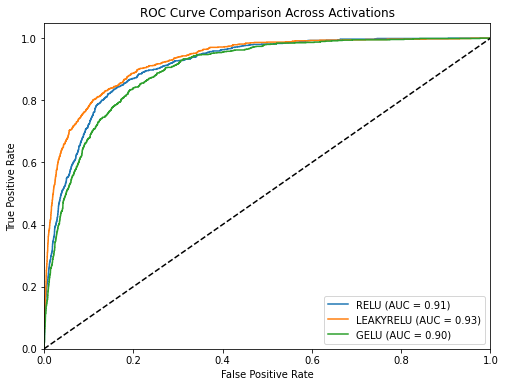

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import gelu
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# ==============================
# Data Preprocessing
# ==============================
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_dir = "C:/Users/MBIZA/Downloads/train/train"
epochs = 5

aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

aug_train = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

aug_val = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

num_classes = len(aug_train.class_indices)
class_names = list(aug_train.class_indices.keys())

# ==============================
# Build CNN with custom activation
# ==============================
def build_model(activation="relu"):
    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape=(*IMG_SIZE, 3)))
    if activation == "leakyrelu":
        model.add(LeakyReLU(alpha=0.01))
    elif activation == "gelu":
        model.add(tf.keras.layers.Activation(gelu))
    else:
        model.add(tf.keras.layers.Activation(activation))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, (3,3)))
    if activation == "leakyrelu":
        model.add(LeakyReLU(alpha=0.01))
    elif activation == "gelu":
        model.add(tf.keras.layers.Activation(gelu))
    else:
        model.add(tf.keras.layers.Activation(activation))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    if activation == "gelu":
        model.add(Dense(128, activation=gelu))
    elif activation == "leakyrelu":
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(Dense(128, activation=activation))

    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# ==============================
# Train & Compare
# ==============================
activations = ["relu", "leakyrelu", "gelu"]
roc_curves = {}

for act in activations:
    print(f"\n🚀 Training model with activation: {act}")
    model = build_model(act)
    history = model.fit(
        aug_train,
        validation_data=aug_val,
        epochs=epochs,
        verbose=1
    )

    # Predictions
    y_true = aug_val.classes
    y_pred_proba = model.predict(aug_val)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Scores
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    print(f"\n📊 {act} -> Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Binarize for ROC
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    # Micro-average ROC
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc = auc(fpr, tpr)

    roc_curves[act] = (fpr, tpr, roc_auc)

# ==============================
# Plot ROC Comparison
# ==============================
plt.figure(figsize=(8,6))
for act, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{act.upper()} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Activations")
plt.legend(loc="lower right")
plt.show()


## Effect of kernel size

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.

🚀 Training with kernel size: (3, 3)
Epoch 1/3
119/119 [==============================] - 177s 1s/step - loss: 2.3244 - accuracy: 0.2040 - val_loss: 2.0529 - val_accuracy: 0.2724
Epoch 2/3
119/119 [==============================] - 190s 2s/step - loss: 2.0158 - accuracy: 0.2919 - val_loss: 1.8224 - val_accuracy: 0.3706
Epoch 3/3
30/30 [==============================] - 31s 935ms/step
Kernel (3, 3) -> F1: 0.281, Precision: 0.324, Recall: 0.325

🚀 Training with kernel size: (5, 5)


C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/3
119/119 [==============================] - 220s 2s/step - loss: 2.3523 - accuracy: 0.1985 - val_loss: 2.0513 - val_accuracy: 0.3073
Epoch 2/3
119/119 [==============================] - 208s 2s/step - loss: 2.0609 - accuracy: 0.2866 - val_loss: 1.8750 - val_accuracy: 0.3601
Epoch 3/3
30/30 [==============================] - 27s 816ms/step
Kernel (5, 5) -> F1: 0.232, Precision: 0.256, Recall: 0.273

🚀 Training with kernel size: (11, 11)


C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/3
119/119 [==============================] - 260s 2s/step - loss: 2.4545 - accuracy: 0.1273 - val_loss: 2.4195 - val_accuracy: 0.1288
Epoch 2/3
119/119 [==============================] - 219s 2s/step - loss: 2.4309 - accuracy: 0.1299 - val_loss: 2.4264 - val_accuracy: 0.1288
Epoch 3/3
30/30 [==============================] - 21s 666ms/step
Kernel (11, 11) -> F1: 0.020, Precision: 0.011, Recall: 0.083


C:\Users\MBIZA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


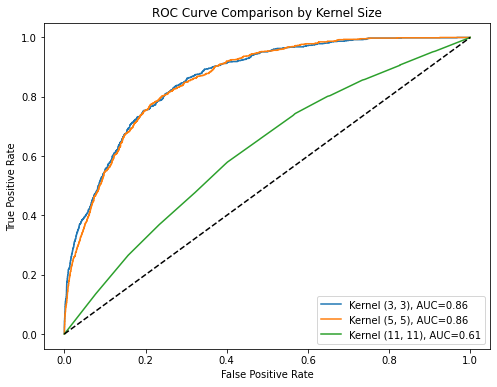

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# Data Preprocessing
# ==============================
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
train_dir = "C:/Users/MBIZA/Downloads/train/train"
epochs = 3  # keep small for testing

# Data generators with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

num_classes = len(train_gen.class_indices)

# ==============================
# Build CNN with variable kernel size
# ==============================
def build_model(kernel_size=(3,3)):
    model = Sequential([
        Conv2D(32, kernel_size, activation="relu", input_shape=(*IMG_SIZE, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, kernel_size, activation="relu"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# ==============================
# Train and Compare
# ==============================
kernel_sizes = [(3,3), (5,5), (11,11)]
histories = {}
roc_results = {}

for k in kernel_sizes:
    print(f"\n🚀 Training with kernel size: {k}")
    model = build_model(k)
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=1)

    # Predictions on validation set
    y_true = val_gen.classes
    y_pred_prob = model.predict(val_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Macro scores (average across classes)
    f1 = f1_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    print(f"Kernel {k} -> F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

    # Compute ROC for One-vs-Rest (macro-average)
    fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true, num_classes).ravel(),
                            y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)

    roc_results[str(k)] = (fpr, tpr, roc_auc)
    histories[str(k)] = history

# ==============================
# Plot ROC Comparison
# ==============================
plt.figure(figsize=(8,6))
for k, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, label=f"Kernel {k}, AUC={roc_auc:.2f}")
plt.plot([0,1], [0,1], "k--")
plt.title("ROC Curve Comparison by Kernel Size")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
